In [2050]:
#general
import os
import random
from datetime import datetime

# data structures
import pandas as pd 
import numpy as np

# visualisation
import matplotlib.pyplot as plt
import seaborn as sns

# data prep
from sklearn.discriminant_analysis import StandardScaler
from sklearn.model_selection import train_test_split

# model and metrics
from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor


from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

## Import data

In [2051]:
data_dir = 'data' #name of folder w/ csv files

def load_all(dir):
    dataframes = []
    for filename in os.listdir(dir):
        f = os.path.join(dir, filename)
        # checking if it is a file
        if os.path.isfile(f):
            try: 
                df = (pd.read_csv(f))
                dataframes.append(df)
            except: print(f'couldn\'t read file {f}')
    return pd.concat(dataframes, ignore_index=True)

df = load_all(data_dir)
print(f'number of records: {len(df)}')

df.head()

number of records: 42488


,name,stars,price,price_per_person,rating,opinions,distance_from_centre,free_cancellation,breakfast,city,date,adults,children
0,Via Amsterdam,3,740,123.33,8.1,17055.0,6600.0,True,False,Amsterdam,2024-07-05,6,0
1,Generator Amsterdam,3,831,138.50,7.8,5161.0,2200.0,True,False,Amsterdam,2024-07-05,6,0
2,Amsterdam ID Aparthotel,3,1111,185.17,8.7,1815.0,4300.0,True,False,Amsterdam,2024-07-05,6,0
3,Travel Hotel Amsterdam,2,540,90.00,6.5,2013.0,350.0,True,False,Amsterdam,2024-07-05,6,0
4,International Budget Hostel City Center,0,596,99.33,6.4,2274.0,1100.0,True,False,Amsterdam,2024-07-05,6,0


## Oczyszczenie danych

### Interpret data types correctly

In [2052]:
#check types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42488 entries, 0 to 42487
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   name                  42488 non-null  object 
 1   stars                 42488 non-null  int64  
 2   price                 42488 non-null  int64  
 3   price_per_person      42488 non-null  float64
 4   rating                42156 non-null  float64
 5   opinions              42230 non-null  float64
 6   distance_from_centre  42488 non-null  float64
 7   free_cancellation     42488 non-null  bool   
 8   breakfast             42488 non-null  bool   
 9   city                  42488 non-null  object 
 10  date                  42488 non-null  object 
 11  adults                42488 non-null  int64  
 12  children              42488 non-null  int64  
dtypes: bool(2), float64(4), int64(4), object(3)
memory usage: 3.6+ MB


In [2053]:
# interpret dates properly
df['date'] = df['date'].apply(lambda x: datetime.strptime(x.split()[0], '%Y-%m-%d'))

### Missing data

In [2054]:
#df.isnull().sum()

def show_missing_values():
    nulls = df.isnull()
    null_values = nulls.sum().sort_values(ascending=False)
    percentage = nulls.sum() / nulls.count()*100
    missing_values = pd.concat([null_values, percentage], axis=1, keys=['Number', 'Percentage'], sort=False)
    return missing_values[missing_values['Percentage'] != 0]

show_missing_values()

,Number,Percentage
rating,332,0.781397
opinions,258,0.607230


Danych brakuje jedynie w dwóch kolumnach i w dość małym procencie rekordów. Nie powinno to mieć wpływu na wyniki

#### reviews

booking nie wyświetla liczby opinii kiedy jest to 0, co odpowiada prawdopodobnie za większość brakujących wartości

In [2055]:
#print(df[df['opinions'].isna()])
df['opinions'] = df['opinions'].fillna(0)

#### rating

In [2056]:
# mean with standard deviation

mean = df['rating'].mean()
std = df['rating'].std()

df['rating'] = df['rating'].fillna(random.uniform(mean - std, mean + std))

### Dropping irrelevant values

Ponieważ dane zebrałam w tym przypadku tylko dla jednego miasta oraz nie uwzględniam udziału dzieci, odpowiednie kolumny zostały usunięte. 

Nazwa hotelu nie będzie miała wpływu na jego cenę

Darmowe odwołanie zamówienia jest zawsze oznaczone jako prawda (prawdopodobnie przez lekko przekłamany sposób wyświetlania bookingu), więc nie będzie miało wpływu na cenę.

W tym raporcie skupiam się na cenie per osoba, więc kolumna z łączną ceną rezerwacji może zostać usunięta.

In [2057]:
free_cancel_num = len(df[df['free_cancellation'] == True])
no_free_cancel_num = len(df[df['free_cancellation'] == False])

print(f'Number of reservations with free_cancellation: {free_cancel_num}')
print(f'Number of reservations with no free_cancellation: {no_free_cancel_num}')

Number of reservations with free_cancellation: 42488
Number of reservations with no free_cancellation: 0


In [2058]:
df = df.drop(columns=['name', 'children', 'city', 'free_cancellation', 'price'])
df


,stars,price_per_person,rating,opinions,distance_from_centre,breakfast,date,adults
0,3,123.33,8.1,17055.0,6600.0,False,2024-07-05,6
1,3,138.50,7.8,5161.0,2200.0,False,2024-07-05,6
2,3,185.17,8.7,1815.0,4300.0,False,2024-07-05,6
3,2,90.00,6.5,2013.0,350.0,False,2024-07-05,6
4,0,99.33,6.4,2274.0,1100.0,False,2024-07-05,6
...,...,...,...,...,...,...,...,...
42483,3,384.60,6.8,1765.0,1100.0,False,2025-09-02,10
42484,3,307.70,6.6,3288.0,250.0,False,2025-09-02,10
42485,5,390.10,9.1,883.0,1000.0,False,2025-09-02,10
42486,0,61.30,8.6,2663.0,1500.0,False,2025-09-02,10


## Dystrybucja wartości

In [2059]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning) #ignore distplot depreciation

#### price per person

min        14.000000
max     11147.000000
mean      181.158681
std       400.679128
Name: price_per_person, dtype: float64


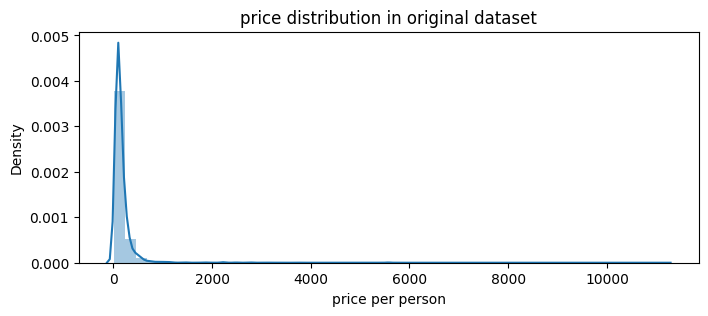

In [2060]:
# calculate price statistics
print(df['price_per_person'].agg(['min','max','mean','std']))

# make plot
plt.figure(figsize=(8,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution in original dataset')
plt.xlabel('price per person')
plt.show()

percent of data removed: 2.34
min      14.000000
max     598.600000
mean    142.909099
std      99.035641
Name: price_per_person, dtype: float64


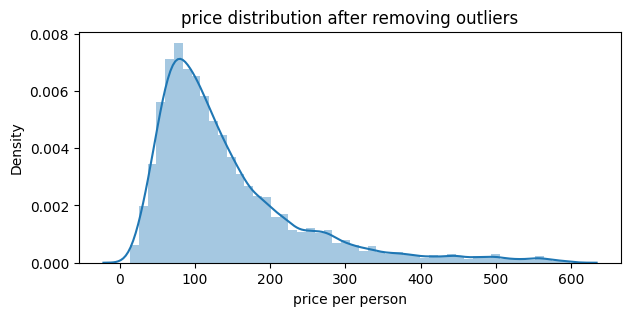

In [2061]:
# remove outliers and count percent of entries removed
old_size = len(df)
df = df[df['price_per_person'] < 600]
percent_removed = round((1 - len(df)/old_size) * 100, 2)
print(f'percent of data removed: {percent_removed}')
#print(len(df))

# calculate price statistics
print(df['price_per_person'].agg(['min','max','mean','std']))

# make plot
plt.figure(figsize=(7,3))
sns.distplot(df['price_per_person'])
#sns.displot(x='price_per_person', data=df, kde=True)
plt.title('price distribution after removing outliers')
plt.xlabel('price per person')
plt.show()



#### date

min   2024-07-05
max   2025-09-02
Name: date, dtype: datetime64[ns]


<Figure size 640x480 with 0 Axes>

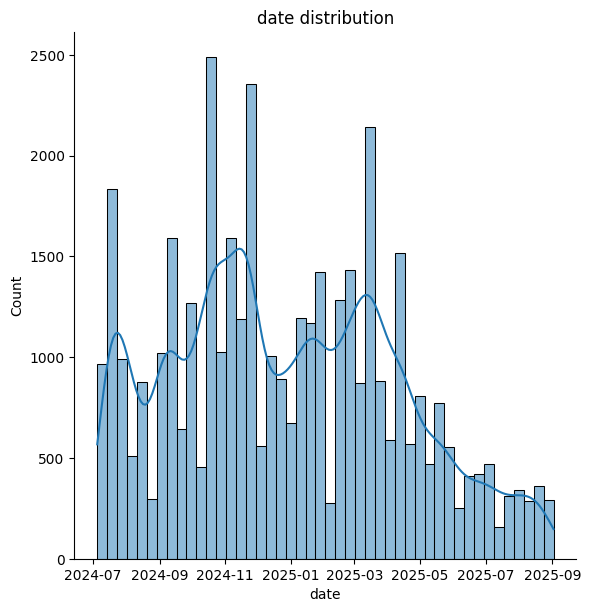

In [2062]:
print(df['date'].agg(['min','max']))

plt.figure()
#sns.distplot(df['date'])
sns.displot(x='date', data=df, kde=True, height=6)
plt.title('date distribution')
plt.show()

#### number of people

min      1.000000
max     10.000000
mean     4.842042
std      2.926455
Name: adults, dtype: float64


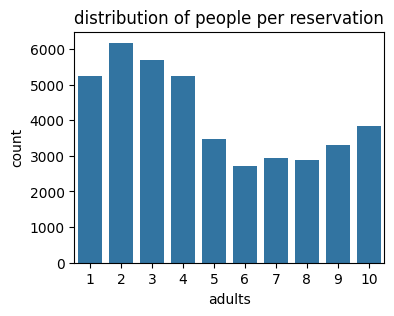

In [2063]:
print(df['adults'].agg(['min','max','mean','std']))

plt.figure(figsize=(4,3))
sns.countplot(x='adults', data=df)
plt.title('distribution of people per reservation')
plt.show()

#### rating

min      4.200000
max     10.000000
mean     7.900555
std      0.864693
Name: rating, dtype: float64


<Figure size 300x300 with 0 Axes>

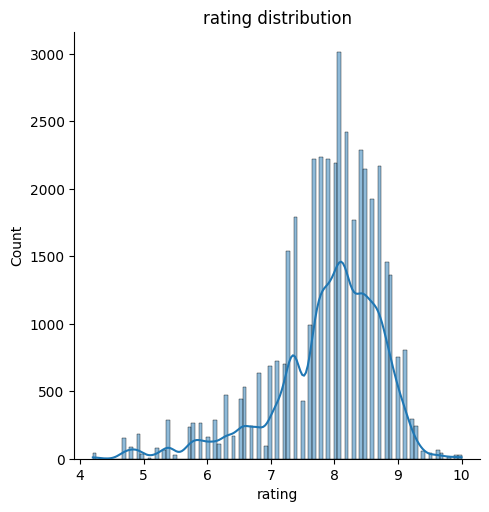

In [2064]:
print(df['rating'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='rating', data=df, kde=True)
plt.title('rating distribution')
plt.show()

#### number of reviews

min         0.000000
max     19967.000000
mean     3424.817194
std      3474.337615
Name: opinions, dtype: float64


<Figure size 300x300 with 0 Axes>

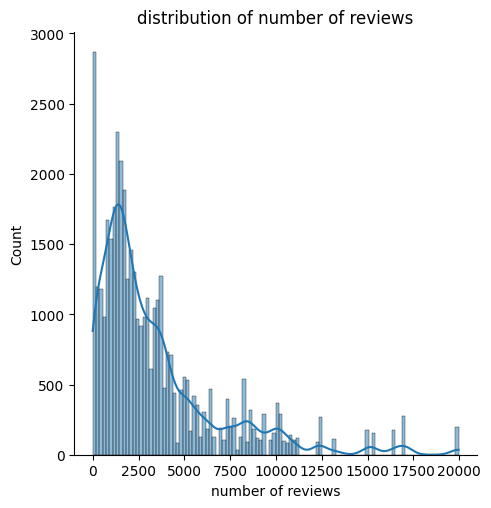

In [2065]:
print(df['opinions'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='opinions', data=df, kde=True)
plt.title('distribution of number of reviews')
plt.xlabel('number of reviews')
plt.show()

#### stars

min     0.000000
max     5.000000
mean    2.894317
std     1.395631
Name: stars, dtype: float64


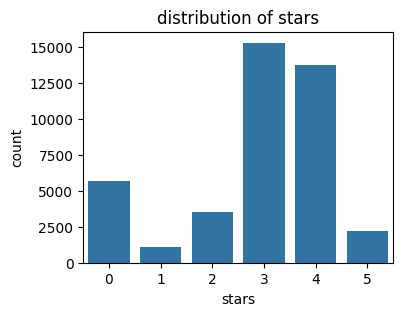

In [2066]:
print(df['stars'].agg(['min','max','mean','std']))

plt.figure(figsize=(4,3))
sns.countplot(x='stars', data=df)
plt.title('distribution of stars')
plt.show()

#### distance from centre

min        50.000000
max     11000.000000
mean     2378.900752
std      2079.471110
Name: distance_from_centre, dtype: float64


<Figure size 300x300 with 0 Axes>

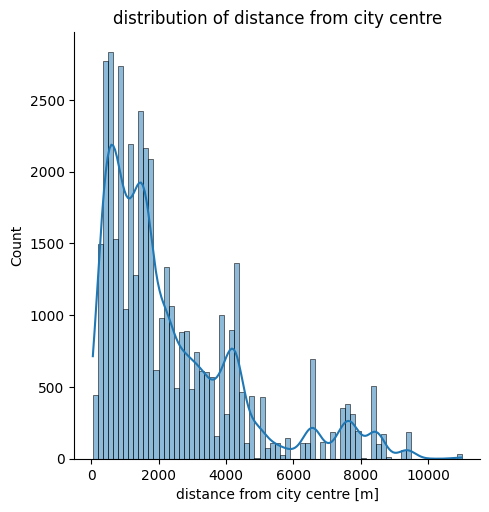

In [2067]:
print(df['distance_from_centre'].agg(['min','max','mean','std']))

plt.figure(figsize=(3,3))
sns.displot(x='distance_from_centre', data=df, kde=True)
plt.title('distribution of distance from city centre')
plt.xlabel('distance from city centre [m]')
plt.show()

#### breakfast

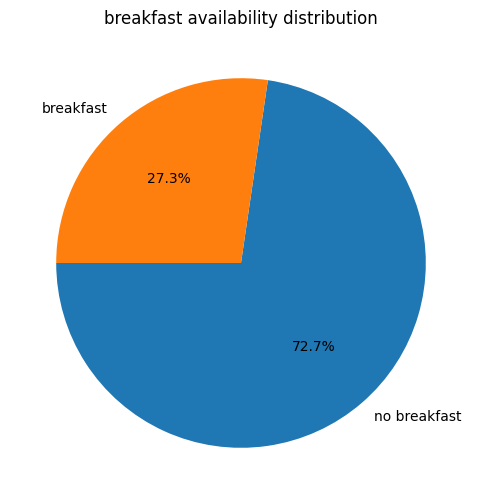

In [2068]:
plt.figure(figsize=(8,6))
breakfast = len(df[df['breakfast'] == 1])
no_breakfast = len(df[df['breakfast'] == 0])
categories=[no_breakfast, breakfast]
labels = ['no breakfast', 'breakfast']
plt.pie(categories, labels=labels, autopct='%1.1f%%', startangle=180)
plt.title('breakfast availability distribution')
plt.show()

## Zależności między danymi

#### price per person to number of people

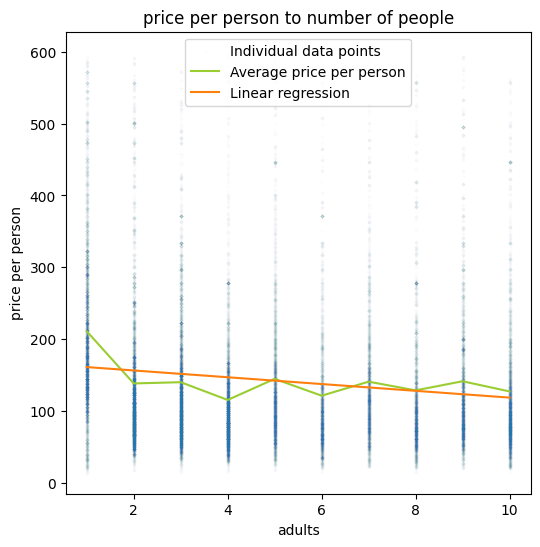

In [2069]:
# Calculate the average price per person for each rating
average_prices = df.groupby('adults')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['adults'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.007)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['adults'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['adults'].min(), stop=df['adults'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to number of people')
plt.xlabel('adults')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### rating a cena p/o

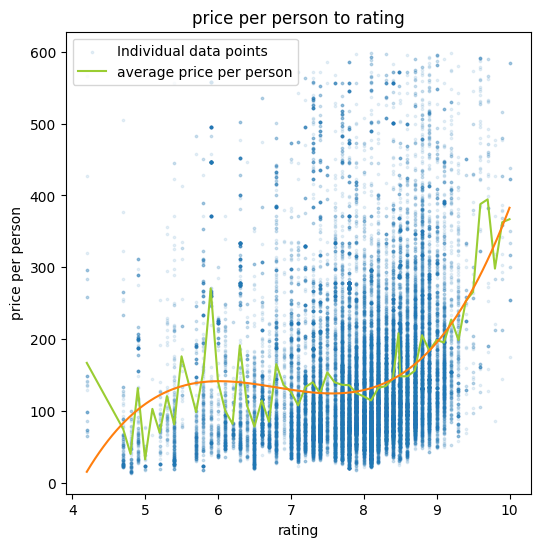

In [2070]:
# Calculate the average price per person for each rating
average_prices = df.groupby('rating')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['rating'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person')

# linear regression using numpy
coef = np.polyfit(df['rating'], df['price_per_person'], 3)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['rating'].min(), stop=df['rating'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange')

plt.title('price per person to rating')
plt.xlabel('rating')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### price per person to stars

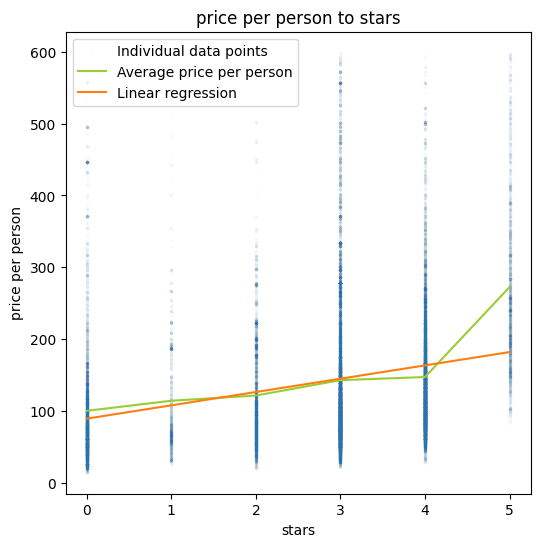

In [2071]:
# Calculate the average price per person per number of stars
average_prices = df.groupby('stars')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['stars'], df['price_per_person'], label='Individual data points', color='tab:blue', s=3, alpha=0.01)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['stars'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['stars'].min(), stop=df['stars'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to stars')
plt.xlabel('stars')
plt.ylabel('price per person')
plt.legend()
plt.show()

<Figure size 600x600 with 0 Axes>

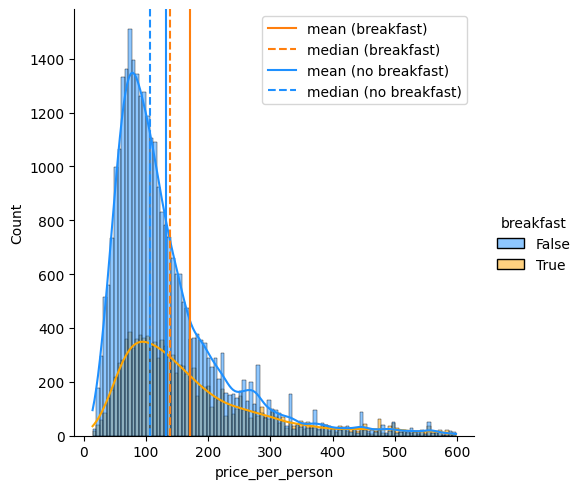

In [2072]:
plt.figure(figsize=(6,6))
sns.displot(x='price_per_person', data=df, hue='breakfast', kde=True, palette = {True: 'orange', False: 'dodgerblue'})

plt.axvline(x=df[df['breakfast'] == True].price_per_person.mean(), c='tab:orange', ls='-', lw=1.5, label='mean (breakfast)')
plt.axvline(x=df[df['breakfast'] == True].price_per_person.median(), c='tab:orange', ls='--', lw=1.5, label='median (breakfast)')

plt.axvline(x=df[df['breakfast'] == False].price_per_person.mean(), c='dodgerblue', ls='-', lw=1.5, label='mean (no breakfast)')
plt.axvline(x=df[df['breakfast'] == False].price_per_person.median(), c='dodgerblue', ls='--', lw=1.5, label='median (no breakfast)')

plt.legend()
plt.show()

#### odległość od centrum a rating

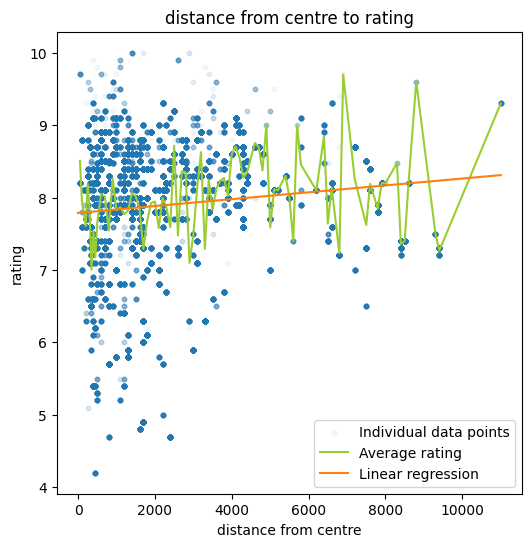

In [2073]:
# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['rating'], label='Individual data points', color='tab:blue', s=10, alpha=0.05)

# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['rating'].mean() 
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average rating')

# linear regression
coef = np.polyfit(df['distance_from_centre'], df['rating'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=0, stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('distance from centre to rating')
plt.xlabel('distance from centre')
plt.ylabel('rating')
plt.legend()
plt.show()

#### odległość od centrum a cena p/o

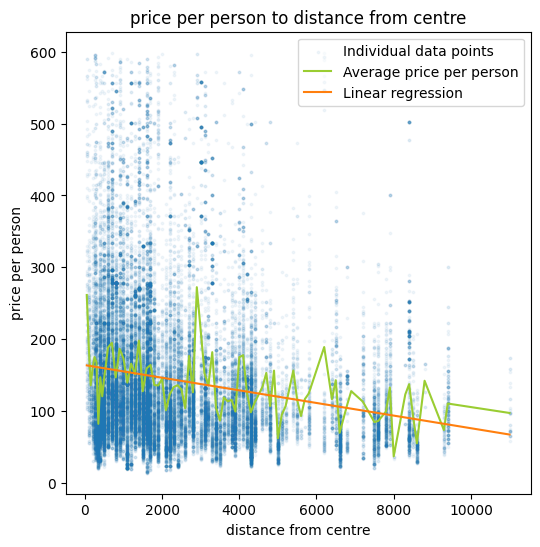

In [2074]:
# Calculate the average price per person for each rating
average_prices = df.groupby('distance_from_centre')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(6,6))
plt.scatter(df['distance_from_centre'], df['price_per_person'], label='Individual data points', s=3, alpha=0.06)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='Average price per person')

# linear regression using numpy
coef = np.polyfit(df['distance_from_centre'], df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(start=df['distance_from_centre'].min(), stop=df['distance_from_centre'].max(), num=300)
plt.plot(x, poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person to distance from centre')
plt.xlabel('distance from centre')
plt.ylabel('price per person')
plt.legend()
plt.show()

#### data a cena p/o

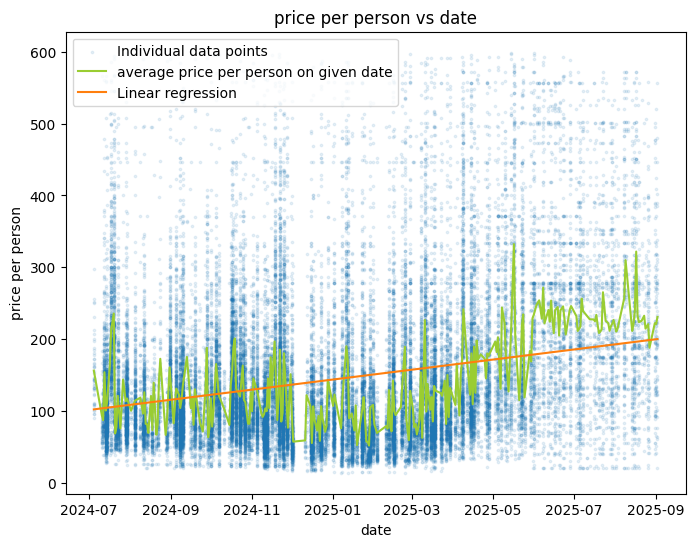

In [2075]:
# Calculate the average price per person for each rating
average_prices = df.groupby('date')['price_per_person'].mean()

# Create the figure and plot
plt.figure(figsize=(8,6))
plt.scatter(df['date'], df['price_per_person'], label='Individual data points', s=3, alpha=0.1)
plt.plot(average_prices.index, average_prices.values, color='yellowgreen', label='average price per person on given date')

# Calculate the difference in days from the reference date
reference_date = pd.to_datetime('2024-07-30')
days_from_reference = (df['date'] - reference_date).dt.days

# linear regression using numpy
coef = np.polyfit(days_from_reference, df['price_per_person'], 1)
poly1d_fn = np.poly1d(coef)

x = np.linspace(days_from_reference.min(), days_from_reference.max(), 300)
plt.plot(reference_date + pd.to_timedelta(x, unit='D'), poly1d_fn(x), color='tab:orange', label='Linear regression')

plt.title('price per person vs date')
plt.xlabel('date')
plt.ylabel('price per person')
plt.legend()
plt.show()

## prepare data

#### split set into attributes and target

In [2076]:
X = df.drop('price_per_person', axis=1)
y = df['price_per_person']

#### Scale the attributes

convert date to ordinal so it can be scaled properly

In [2077]:
X['date'] = X['date'].map(datetime.toordinal)
#X['date'] = X['date'].map(lambda x: x.month)

In [2078]:
#check types
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 41492 entries, 0 to 42487
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   stars                 41492 non-null  int64  
 1   rating                41492 non-null  float64
 2   opinions              41492 non-null  float64
 3   distance_from_centre  41492 non-null  float64
 4   breakfast             41492 non-null  bool   
 5   date                  41492 non-null  int64  
 6   adults                41492 non-null  int64  
dtypes: bool(1), float64(3), int64(3)
memory usage: 2.3 MB


In [2079]:
scaler = StandardScaler()
X = scaler.fit_transform(X)
#print(X)

#### create training and test data set

In [2080]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=random.randint(0,100), shuffle = True)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(37342, 7) (4150, 7) (37342,) (4150,)


## actual regression

In [2170]:
results = []

In [2171]:
def evaluate(y_pred):
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)

    print("Mean Absolute Error (MAE):", mae)
    print("Mean Squared Error (MSE):", mse)
    print("R-squared (R²):", r2)

    return {'mae':mae, 'mse':mse, 'r2':r2}

#### Linear Least Squares

In [2172]:
# train model
reg = linear_model.LinearRegression()
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['lls']))

[ 24.45805091   8.7332186  -18.02692644 -15.48886773  11.75887755
  23.31126848  -6.72700836]
Mean Absolute Error (MAE): 61.738926854208785
Mean Squared Error (MSE): 7684.673358566058
R-squared (R²): 0.2157113725919818


#### Non-Negative Least Squares

In [2173]:
# train model
reg = linear_model.LinearRegression(positive=True)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['non-negative lls']))

[22.78940873  6.03135731  0.          0.         16.39422485 22.97055439
  0.        ]
Mean Absolute Error (MAE): 65.28972322117083
Mean Squared Error (MSE): 8477.519946113896
R-squared (R²): 0.13479439240571445


#### Ridge

In [2174]:
# train model
reg = linear_model.Ridge(alpha=0.8, max_iter=100, solver='auto')
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['ridge']))

[ 24.45749846   8.73322043 -18.02662451 -15.48858823  11.75864263
  23.31079179  -6.72699433]
Mean Absolute Error (MAE): 61.73886466840371
Mean Squared Error (MSE): 7684.67063663294
R-squared (R²): 0.2157116503892399


#### Lasso

In [2175]:
# train model
reg = linear_model.Lasso(alpha=0.5)
reg.fit(X_train, y_train)

print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(X_test)
results.append(pd.DataFrame(evaluate(y_pred), index=['lasso']))

[ 24.05840849   8.35875538 -17.65773535 -15.02695611  11.53674542
  22.82005632  -6.36551489]
Mean Absolute Error (MAE): 61.69505188342119
Mean Squared Error (MSE): 7683.1462510252095
R-squared (R²): 0.21586722737216968


polynomial least squares

In [2187]:
# function to test ls for a specific degree
def poly_ls(degree: int):
    # get polynomial
    trans = PolynomialFeatures(degree)
    X_poly = trans.fit_transform(X=X_train, y=y_train)

    # train model
    reg = linear_model.LinearRegression()
    reg.fit(X_poly, y_train)

    #print(reg.coef_)

    # make predictions on the test data
    y_pred = reg.predict(trans.transform(X_test))
    results.append(pd.DataFrame(evaluate(y_pred), index=[f'ls {degree} degree']))

In [2188]:
# test polynomial least squares for various degrees
degrees = [2, 3, 5, 7]
for n in degrees: poly_ls(n)

[-2.54418800e+05  3.56812640e+01  8.47329722e+00 -2.16971696e+01
 -2.23955668e+01 -1.65895825e+10  1.75037453e+01 -7.22172433e+01
  1.08375004e+01  5.31321827e+00  2.98163029e+00 -6.83851246e+00
  2.00652724e+00  4.73646593e+00 -3.48103699e-01  3.77826558e+00
 -9.66717243e+00 -8.09041037e+00 -6.57079850e-01 -9.57504264e+00
 -3.26381204e+00  3.09749938e+00  4.48520550e+00 -2.42337473e+00
 -2.57270248e+00 -3.56020002e-01  3.65128381e+00 -3.52624042e-01
  6.47814133e-01  3.21092732e+00  1.63001173e+10  1.64615367e+00
 -1.09709274e+02  2.07593162e+01  1.86284876e+00  1.87921658e+00]
Mean Absolute Error (MAE): 52.86995995887848
Mean Squared Error (MSE): 6368.949632465117
R-squared (R²): 0.34999257194076194
[ 8.88152886e+08 -4.40516641e+12  2.97736866e+12 -1.17833407e+12
 -2.54858746e+12 -2.01218691e+12 -5.56215365e+11 -2.24723593e+11
  1.43776569e+01  7.18820721e+00 -5.44570909e+00 -1.49728539e+01
 -4.48339541e+12 -2.11550293e+00 -1.95525502e+01  1.09210853e+01
 -5.28827892e+00 -1.42203491e

random forest

In [2179]:
# get polynomial
trans = PolynomialFeatures(1)
X_poly = trans.fit_transform(X=X_train, y=y_train)

print(X_poly)

# train model
reg = RandomForestRegressor(n_estimators=10)
reg.fit(X_poly, y_train)

#print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(trans.transform(X_test))
results.append(pd.DataFrame(evaluate(y_pred), index=['random forest 10 trees']))

[[ 1.         -2.07386618  0.23065643 ... -0.61315378  0.32027801
   1.76254885]
 [ 1.          0.79225553 -0.23194124 ... -0.61315378  0.24388967
   0.39569104]
 [ 1.          0.79225553  1.15585179 ... -0.61315378  1.1510013
   1.4208344 ]
 ...
 [ 1.          0.79225553 -0.23194124 ...  1.63091224 -1.0642608
  -0.97116677]
 [ 1.         -0.64080533 -1.50408485 ... -0.61315378  0.25343821
   1.4208344 ]
 [ 1.          0.0757251  -1.50408485 ... -0.61315378  0.66402558
   0.73740549]]
Mean Absolute Error (MAE): 19.087236144578313
Mean Squared Error (MSE): 1056.3909526616867
R-squared (R²): 0.8921859952126993


In [2180]:
# get polynomial
trans = PolynomialFeatures(1)
X_poly = trans.fit_transform(X=X_train, y=y_train)

print(X_poly)

# train model
reg = RandomForestRegressor(n_estimators=30)
reg.fit(X_poly, y_train)

#print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(trans.transform(X_test))
results.append(pd.DataFrame(evaluate(y_pred), index=['random forest 30 trees']))

[[ 1.         -2.07386618  0.23065643 ... -0.61315378  0.32027801
   1.76254885]
 [ 1.          0.79225553 -0.23194124 ... -0.61315378  0.24388967
   0.39569104]
 [ 1.          0.79225553  1.15585179 ... -0.61315378  1.1510013
   1.4208344 ]
 ...
 [ 1.          0.79225553 -0.23194124 ...  1.63091224 -1.0642608
  -0.97116677]
 [ 1.         -0.64080533 -1.50408485 ... -0.61315378  0.25343821
   1.4208344 ]
 [ 1.          0.0757251  -1.50408485 ... -0.61315378  0.66402558
   0.73740549]]
Mean Absolute Error (MAE): 18.927340240963854
Mean Squared Error (MSE): 1058.9643220711648
R-squared (R²): 0.8919233601899987


In [2181]:
# get polynomial
trans = PolynomialFeatures(1)
X_poly = trans.fit_transform(X=X_train, y=y_train)

print(X_poly)

# train model
reg = RandomForestRegressor(n_estimators=100)
reg.fit(X_poly, y_train)

#print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(trans.transform(X_test))
results.append(pd.DataFrame(evaluate(y_pred), index=['random forest 100 trees']))

[[ 1.         -2.07386618  0.23065643 ... -0.61315378  0.32027801
   1.76254885]
 [ 1.          0.79225553 -0.23194124 ... -0.61315378  0.24388967
   0.39569104]
 [ 1.          0.79225553  1.15585179 ... -0.61315378  1.1510013
   1.4208344 ]
 ...
 [ 1.          0.79225553 -0.23194124 ...  1.63091224 -1.0642608
  -0.97116677]
 [ 1.         -0.64080533 -1.50408485 ... -0.61315378  0.25343821
   1.4208344 ]
 [ 1.          0.0757251  -1.50408485 ... -0.61315378  0.66402558
   0.73740549]]
Mean Absolute Error (MAE): 18.323370602409643
Mean Squared Error (MSE): 990.2393538110795
R-squared (R²): 0.8989373487501344


k-neighbours

In [2182]:
# get polynomial
trans = PolynomialFeatures(1)
X_poly = trans.fit_transform(X=X_train, y=y_train)

print(X_poly)

# train model
reg = KNeighborsRegressor(n_neighbors=5)
reg.fit(X_poly, y_train)

#print(reg.coef_)

# make predictions on the test data
y_pred = reg.predict(trans.transform(X_test))
results.append(pd.DataFrame(evaluate(y_pred), index=['k-neighbours']))

[[ 1.         -2.07386618  0.23065643 ... -0.61315378  0.32027801
   1.76254885]
 [ 1.          0.79225553 -0.23194124 ... -0.61315378  0.24388967
   0.39569104]
 [ 1.          0.79225553  1.15585179 ... -0.61315378  1.1510013
   1.4208344 ]
 ...
 [ 1.          0.79225553 -0.23194124 ...  1.63091224 -1.0642608
  -0.97116677]
 [ 1.         -0.64080533 -1.50408485 ... -0.61315378  0.25343821
   1.4208344 ]
 [ 1.          0.0757251  -1.50408485 ... -0.61315378  0.66402558
   0.73740549]]
Mean Absolute Error (MAE): 33.693307469879514
Mean Squared Error (MSE): 3039.1410421407227
R-squared (R²): 0.6898288781808822


In [2183]:
results_df = pd.concat(results)
results_df

,mae,mse,r2
lls,61.738927,7684.673359,0.215711
non-negative lls,65.289723,8477.519946,0.134794
ridge,61.738865,7684.670637,0.215712
lasso,61.695052,7683.146251,0.215867
ls 2nd degree,52.869960,6368.949632,0.349993
ls 3rd degree,50.170987,5770.737358,0.411045
ls 4th degree,46.661825,5007.725245,0.488918
random forest 10 trees,19.087236,1056.390953,0.892186
random forest 30 trees,18.927340,1058.964322,0.891923
random forest 100 trees,18.323371,990.239354,0.898937


Text(0, 0.5, 'model')

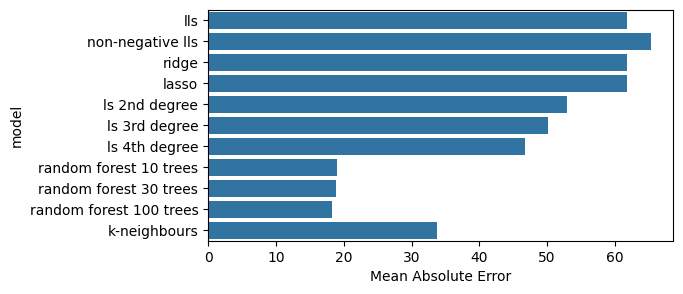

In [2184]:
plt.figure(figsize= (6, 3))
sns.barplot(y=results_df.index, x=results_df.mae)
plt.xlabel('Mean Absolute Error')
plt.ylabel('model')

Text(0, 0.5, 'model')

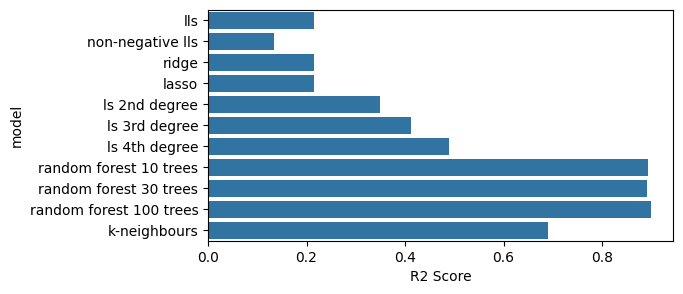

In [2185]:
plt.figure(figsize= (6, 3))
sns.barplot(y=results_df.index, x=results_df.r2)
plt.xlabel('R2 Score')
plt.ylabel('model')